In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.metrics import f1_score
import numpy as np

import langid
import json
import pandas as pd
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from collections import defaultdict

from scipy.stats import entropy
from bisect import bisect

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


countries = {'Italy': 'it', 
             'Denmark': 'da', 
             'Germany': 'de',
             'France': 'fr',
             'Netherlands': 'nl',
             'Sweden': 'sv',
             'United States': 'us', 'United Kingdom': 'uk'}
lang2country = {v:k for k, v in countries.items()}
age_brackets = '0-14|15-24|25-54|55-64|65+'.split('|')
breakpoints = [15,25,55,65]
gender2id = {'F': 0, 'M': 1}
age2id = {cat: i for i, cat in enumerate(age_brackets[1:])}

In [149]:
def map_decade(n):
    if 0 <= n < 10:
        return 0
    elif 10 <= n < 20:
        return 1
    elif 20 <= n < 30:
        return 2
    elif 30 <= n < 40:
        return 3
    elif 40 <= n < 50:
        return 4
    elif 50 <= n < 60:
        return 5
    elif 60 <= n < 70:
        return 6
    else:
        return 7

def get_split(a):
    c = Counter(a)
    total = sum(c.values())
    return ' : '.join(['{}'.format(round(c[cat]/total*100)) for cat in sorted(c.keys())])

def get_kl(a, b):
    epsilon = 0.00000001
    c1 = Counter(a)
    total1 = sum(c1.values()) + len(c1)*epsilon
    c1c = [(c1[cat]+epsilon)/total1 for cat in sorted(c1.keys())]

    c2 = Counter(b)
    total2 = sum(c2.values())+ len(c1)*epsilon
    c2c = [(c2[cat]+epsilon)/total2 for cat in sorted(c1.keys())]


    return '%.3f' % entropy(c1c, c2c)


from scipy.stats import chi2_contingency
def get_significance(P,Q):
    A = Counter(P)
    B = Counter(Q)

    a = np.zeros((2,len(A)), dtype=int)
    
    for key, value in sorted(A.items()):
        a[0, key] = value
    for key, value in sorted(B.items()):
        a[1, key] = value

    g,p, dof, E = chi2_contingency(a)
    significance = ''
    if p <= 0.01:
        significance = '$^{**}$'
    elif p <= 0.05:
        significance = '$^{*}$'
    return significance


In [4]:
def collect_data(json_file, lang, country, age_distro, test_samples=200, train_samples=2500):
    instances = []
    test_distro = {'M':defaultdict(int), 'F':defaultdict(int)}
    train_distro = {'M':defaultdict(int), 'F':defaultdict(int)}


    for i, line in enumerate(open(json_file)):
        if i > 0:
            if i % 1000 == 0:
                print('{} ({} instances)'.format(i, len(instances)), flush=True)
            elif i % 50 == 0:
                print('.', end='', flush=True)

            
        data = json.loads(line.strip())
        birth_year = data.get('birth_year')
        gender = data.get('gender')

        if birth_year is not None and gender is not None:
            birth_year = int(birth_year)
            for review in data['reviews']:
                # make sure language is correct
                if langid.classify(' '.join(review['text']))[0] != lang:
                    continue

                label = None
                if review.get('date') is not None:
                    # compute age at posting
                    age = int(review['date'][:4]) - birth_year
                    age_bracket = bisect(breakpoints, age)
                    # ignore under 15s
                    if age_bracket == 0:
                        continue
                    age_cat = age_brackets[age_bracket]

                    # add to test sample if group is still undersampled
                    if test_distro[gender][age_cat] <= (age_distro[country][gender][age_cat] *  test_samples):
                        test_distro[gender][age_cat] += 1
                        label = 'test'

                    # add to train sample if group is still undersampled
                    elif train_distro[gender][age_cat] <= (age_distro[country][gender][age_cat] *  train_samples):
                        train_distro[gender][age_cat] += 1
                        label = 'train'


                    if label is not None:
                        instances.append((' '.join(review['text']).replace('\n', ' ').strip(), age, age_cat, gender, label))
    return instances

In [5]:
values_m = []
values_f = []
record = False

age_distro = {}
for row in open('data/age_facts.txt'):
    row = row.strip()

    if record and (row[0] == '0' or row[0] == '1' or row[0] == '2' or row[0] == '5'):
        elements = row.replace(',', '').replace(')', '').split()
        values_m.append(int(elements[4]))
        values_f.append(int(elements[6]))

    elif record and row[0] == '6':
        elements = row.replace(',', '').replace(')', '').split()
        values_m.append(int(elements[6]))
        values_f.append(int(elements[8]))

        sum_m = sum(values_m[1:])
        values_m = [value/sum_m for value in values_m[1:]]
        
        sum_f = sum(values_f[1:])
        values_f = [value/sum_f for value in values_f[1:]]

        age_distro[countries[country]] = {'M': dict(zip(age_brackets[1:], values_m)), 'F': dict(zip(age_brackets[1:], values_f))}

        values_m = []
        values_f = []
        record = False
        
    else:
        if row in countries:
            country = row
            record = True
age_distro

{'da': {'M': {'15-24': 0.15716506553858337,
   '25-54': 0.47812782628628586,
   '55-64': 0.14873194823598057,
   '65+': 0.21597515993915017},
  'F': {'15-24': 0.1465849598104401,
   '25-54': 0.45754491323753205,
   '55-64': 0.14677165997691782,
   '65+': 0.24909846697511004}},
 'fr': {'M': {'15-24': 0.15276796259184233,
   '25-54': 0.47838667250217254,
   '55-64': 0.15161417516918108,
   '65+': 0.21723118973680405},
  'F': {'15-24': 0.13725741765651378,
   '25-54': 0.44223211603112583,
   '55-64': 0.1530613445558388,
   '65+': 0.2674491217565216}},
 'de': {'M': {'15-24': 0.1196946014732823,
   '25-54': 0.47323152505109517,
   '55-64': 0.17514820278434567,
   '65+': 0.23192567069127687},
  'F': {'15-24': 0.10946249754655234,
   '25-54': 0.4423169761437796,
   '55-64': 0.16826877888452899,
   '65+': 0.279951747425139}},
 'it': {'M': {'15-24': 0.11665705513461495,
   '25-54': 0.5003960179742142,
   '55-64': 0.1563129612483596,
   '65+': 0.22663396564281127},
  'F': {'15-24': 0.10615032395

# Extract balanced data

In [671]:
for (lang, country, lang_file) in [('it', 'it', '../data/JSON/italy.auto-adjusted_gender.NUTS-regions.jsonl'),
                                  ('de', 'de', '../data/JSON/germany.auto-adjusted_gender.NUTS-regions.jsonl'),
                                  ('fr', 'fr', '../data/JSON/france.auto-adjusted_gender.NUTS-regions.jsonl'),
                                  ('nl', 'nl', '../data/JSON/netherlands.auto-adjusted_gender.NUTS-regions.jsonl')
                                  ]:
    df_new = pd.DataFrame(collect_data(lang_file, 
                                      lang, country,
                                      age_distro),
                     columns='text age age_cat gender label'.split()
                    )
    
    # add translations
    google_translation = pd.read_excel('data/{}/{}.xlsx'.format(lang, lang), encoding='utf8')
    bing_translation = pd.read_excel('data/{}/{}_bing.xlsx'.format(lang, lang), encoding='utf8')
    deepl_translation = pd.read_excel('data/{}/{}_deepl.xlsx'.format(lang, lang), encoding='utf8')

    assert (df_new[df_new.label == 'test'].text.values == google_translation[google_translation.label == 'test'].text.values).all()
    assert (df_new[df_new.label == 'test'].text.values == bing_translation[bing_translation.label == 'test'].text.values).all()
    assert (df_new[df_new.label == 'test'].text.values == deepl_translation[deepl_translation.label == 'test'].text.values).all()

    df_test = df_new[df_new.label=='test']
    df_test.loc[df_test.label=='test', 'google_translation'] = google_translation[google_translation.label == 'test']['translation'].values
    df_test.loc[df_test.label=='test', 'bing_translation'] = bing_translation[bing_translation.label == 'test']['bing_translation'].values
    df_test.loc[df_test.label=='test', 'deepl_translation'] = deepl_translation[deepl_translation.label == 'test']['deepl_translation'].values

    df_test.to_excel('data/{}/{}_TEST.xlsx'.format(lang, lang), encoding='utf8')
    df_new[df_new.label=='train'].to_excel('data/{}/{}_TRAIN.xlsx'.format(lang, lang), encoding='utf8')



...................1000 (32 instances)
...................2000 (65 instances)
...................3000 (89 instances)
...................4000 (119 instances)
...................5000 (145 instances)
...................6000 (164 instances)
...................7000 (193 instances)
...................8000 (223 instances)
...................9000 (254 instances)
...................10000 (287 instances)
...................11000 (341 instances)
...................12000 (398 instances)
...................13000 (449 instances)
...................14000 (473 instances)
...................15000 (495 instances)
...................16000 (513 instances)
...................17000 (532 instances)
...................18000 (562 instances)
...................19000 (599 instances)
...................20000 (638 instances)
...................21000 (664 instances)
...................22000 (699 instances)
...................23000 (727 instances)
...................24000 (762 instances)
...................25000 (79

...................195000 (4123 instances)
...................196000 (4131 instances)
...................197000 (4142 instances)
...................198000 (4144 instances)
...................199000 (4152 instances)
...................200000 (4153 instances)
...................201000 (4169 instances)
...................202000 (4179 instances)
...................203000 (4180 instances)
...................204000 (4184 instances)
...................205000 (4188 instances)
...................206000 (4192 instances)
...................207000 (4193 instances)
...................208000 (4196 instances)
...................209000 (4198 instances)
...................210000 (4203 instances)
...................211000 (4216 instances)
...................212000 (4224 instances)
...................213000 (4231 instances)
...................214000 (4236 instances)
...................215000 (4241 instances)
...................216000 (4244 instances)
...................217000 (4251 instances)
...........

...................386000 (4855 instances)
...................387000 (4864 instances)
...................388000 (4865 instances)
...................389000 (4865 instances)
...................390000 (4865 instances)
...................391000 (4866 instances)
...................392000 (4866 instances)
...................393000 (4868 instances)
...................394000 (4868 instances)
...................395000 (4871 instances)
...................396000 (4877 instances)
...................397000 (4877 instances)
...................398000 (4877 instances)
...................399000 (4882 instances)
...................400000 (4884 instances)
...................401000 (4885 instances)
...................402000 (4885 instances)
...................403000 (4903 instances)
...................404000 (4909 instances)
...................405000 (4912 instances)
...................406000 (4913 instances)
...................407000 (4913 instances)
...................408000 (4913 instances)
...........

...................577000 (5059 instances)
...................578000 (5061 instances)
...................579000 (5061 instances)
...................580000 (5061 instances)
...................581000 (5061 instances)
...................582000 (5061 instances)
...................583000 (5064 instances)
...................584000 (5064 instances)
...................585000 (5064 instances)
...................586000 (5069 instances)
...................587000 (5069 instances)
...................588000 (5069 instances)
...................589000 (5069 instances)
...................590000 (5069 instances)
...................591000 (5069 instances)
...................592000 (5069 instances)
...................593000 (5069 instances)
...................594000 (5069 instances)
...................595000 (5069 instances)
...................596000 (5073 instances)
...................597000 (5073 instances)
...................598000 (5073 instances)
...................599000 (5075 instances)
...........

/Users/dirkhovy/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/dirkhovy/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


...................1000 (102 instances)
...................2000 (219 instances)
...................3000 (338 instances)
...................4000 (434 instances)
...................5000 (591 instances)
...................6000 (698 instances)
...................7000 (798 instances)
...................8000 (897 instances)
...................9000 (993 instances)
...................10000 (1084 instances)
...................11000 (1179 instances)
...................12000 (1242 instances)
...................13000 (1331 instances)
...................14000 (1419 instances)
...................15000 (1525 instances)
...................16000 (1642 instances)
...................17000 (1741 instances)
...................18000 (1867 instances)
...................19000 (1976 instances)
...................20000 (2059 instances)
...................21000 (2158 instances)
...................22000 (2273 instances)
...................23000 (2349 instances)
...................24000 (2425 instances)
..........

...................385000 (5408 instances)
...................386000 (5408 instances)
...................387000 (5408 instances)
...................388000 (5408 instances)
...................389000 (5408 instances)
...................390000 (5408 instances)
...................391000 (5408 instances)
...................392000 (5408 instances)
...................393000 (5408 instances)
...................394000 (5408 instances)
...................395000 (5408 instances)
...................396000 (5408 instances)
...................397000 (5408 instances)
...................398000 (5408 instances)
...................399000 (5408 instances)
...................400000 (5408 instances)
...................401000 (5408 instances)
...................402000 (5408 instances)
...................403000 (5408 instances)
...................404000 (5408 instances)
...................405000 (5408 instances)
...................406000 (5408 instances)
...................407000 (5408 instances)
...........

...................576000 (5408 instances)
...................577000 (5408 instances)
...................578000 (5408 instances)
...................579000 (5408 instances)
...................580000 (5408 instances)
...................581000 (5408 instances)
...................582000 (5408 instances)
...................583000 (5408 instances)
...................584000 (5408 instances)
...................585000 (5408 instances)
...................586000 (5408 instances)
...................587000 (5408 instances)
...................588000 (5408 instances)
...................589000 (5408 instances)
...................590000 (5408 instances)
...................591000 (5408 instances)
...................592000 (5408 instances)
..........

# START HERE!

In [158]:
res = {'gender':[], 'age_cat':[], 'decade':[]}
train_sets_X = {}
test_sets_X = {}
train_sets_y = {'gender':{}, 'age_cat':{}, 'decade':{}}
test_sets_y = {'gender':{}, 'age_cat':{}, 'decade':{}}
vectorizers = {}

predictions_org = {'gender': defaultdict(list), 'age_cat': defaultdict(list), 'decade': defaultdict(list)}

base_macro_f1 = {'gender': {'de': 0.65, 'en_us': 0.62, 'fr': 0.64, 'it': 0.62, 'nl': 0.66},
                 'age_cat': {'de': 0.52, 'en_us': 0.53, 'fr': 0.45, 'it': 0.52, 'nl': 0.49},
                 'decade': {'de': 0.27, 'en_us': 0.27, 'fr': 0.22, 'it': 0.30, 'nl': 0.27}
}


for lang in 'de en_us fr it nl'.split():
    train = pd.read_excel('data/{}/{}_TRAIN.xlsx'.format(lang, lang), encoding='utf8')
    test = pd.read_excel('data/{}/{}_TEST.xlsx'.format(lang, lang), encoding='utf8')
    
    vectorizer_lang = TfidfVectorizer(analyzer='char', ngram_range=(2,6), sublinear_tf=True, min_df=0.001, max_df=0.6)
    vectorizers[lang] = vectorizer_lang
    
    X_lang = vectorizer_lang.fit_transform(train.text.apply(str).values)
    Z_lang = vectorizer_lang.transform(test.text.apply(str).values)
        
    train_sets_X[lang] = X_lang
    test_sets_X[lang] = Z_lang

    for target in 'gender age_cat decade'.split():
        print(lang, target)

        if target == 'gender':
            y_lang = [gender2id[g] for g in train[target].values] 
        elif target == 'age_cat':
            y_lang = [age2id[g] for g in train[target].values]
        elif target == 'decade':
            y_lang = [map_decade(g) for g in train['age'].values]
            
        train_sets_y[target][lang] = y_lang

        # find best setting
        base_clf = CalibratedClassifierCV(cv=5,
            base_estimator=LogisticRegression(n_jobs=-1,
                                              solver='saga',
                                              multi_class='auto',
                                              class_weight='balanced'
                                             )
        )
        param_grid = {'base_estimator__C': [5.0, 2.0, 1.0, 0.5, 0.1]}
        search = GridSearchCV(base_clf, param_grid, cv=3, scoring='f1_micro', n_jobs=-1)

        # selector = SelectKBest(chi2, k=9000).fit(X_lang, y_lang)

        # X_sel = selector.transform(X_lang)
        # Z_sel = selector.transform(Z_lang)
        X_sel, Z_sel = X_lang, Z_lang

        search.fit(X_sel, y_lang)

        print(search.best_estimator_.base_estimator, search.best_score_)
        
        X_sel, Z_sel = X_lang, Z_lang
        clf = search.best_estimator_.base_estimator#LogisticRegression(class_weight='balanced', solver='saga')
        clf.fit(X_sel, y_lang)

        preds_org = clf.predict(Z_sel)
        predictions_org[target][lang] = preds_org
        
        if target == 'gender':
            z_lang = [gender2id[g] for g in test[target].values] 
        elif target == 'age_cat':
            z_lang = [age2id[g] for g in test[target].values]
        elif target == 'decade':
            z_lang = [map_decade(g) for g in test['age'].values]

        test_sets_y[target][lang] = z_lang
        
        score = f1_score(preds_org, z_lang, average='micro')
        print(score)
        print()
        res[target].append(score)

de gender
LogisticRegression(C=0.5, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False) 0.6098901098901099
0.6600496277915633

de age_cat
LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False) 0.5210989010989011
0.4640198511166253

de decade


/Users/dirkhovy/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dirkhovy/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dirkhovy/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dirkhovy/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dirkhovy/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: T

LogisticRegression(C=2.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False) 0.27714285714285714


/Users/dirkhovy/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.2655086848635236

en_us gender
LogisticRegression(C=2.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False) 0.6594724220623501
0.6228287841191067

en_us age_cat
LogisticRegression(C=0.5, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False) 0.5163868904876099
0.4441687344913151

en_us decade


/Users/dirkhovy/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dirkhovy/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dirkhovy/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dirkhovy/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dirkhovy/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: T

LogisticRegression(C=2.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False) 0.3205435651478817


/Users/dirkhovy/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.2555831265508685

fr gender
LogisticRegression(C=2.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False) 0.6522192123359033
0.6386138613861386

fr age_cat
LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False) 0.48072515107314023
0.3910891089108911

fr decade


/Users/dirkhovy/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dirkhovy/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dirkhovy/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dirkhovy/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dirkhovy/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: T

LogisticRegression(C=5.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False) 0.24963534069597834


/Users/dirkhovy/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.25742574257425743

it gender
LogisticRegression(C=5.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False) 0.640665626625065
0.6157760814249363

it age_cat
LogisticRegression(C=0.5, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False) 0.6341653666146646
0.4198473282442748

it decade


/Users/dirkhovy/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dirkhovy/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dirkhovy/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dirkhovy/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dirkhovy/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: T

LogisticRegression(C=5.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False) 0.28211128445137806


/Users/dirkhovy/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.2544529262086514

nl gender
LogisticRegression(C=0.5, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False) 0.6147852147852148
0.6550868486352357

nl age_cat
LogisticRegression(C=2.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False) 0.4997002997002997
0.4317617866004963

nl decade


/Users/dirkhovy/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dirkhovy/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dirkhovy/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dirkhovy/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dirkhovy/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: T

LogisticRegression(C=5.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False) 0.2949050949050949
0.2679900744416873



/Users/dirkhovy/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


# Translations INTO english

## fit classifiers

In [58]:
translation_into_en = {'de':{}, 'fr':{}, 'it':{}, 'nl':{}}

predictions_into_en = {'gender': {'de':{}, 'fr':{}, 'it':{}, 'nl':{}}, 
                       'age_cat': {'de':{}, 'fr':{}, 'it':{}, 'nl':{}},
                       'decade': {'de':{}, 'fr':{}, 'it':{}, 'nl':{}},
                      }

for target in 'gender age_cat decade'.split():
    clf_en = LogisticRegression(class_weight='balanced')
    clf_en.fit(train_sets_X['en_us'], train_sets_y[target]['en_us'])

    for lang in 'de fr it nl'.split():
        test = pd.read_excel('data/{}/{}_TEST.xlsx'.format(lang, lang), encoding='utf8')

        for transl in 'google_translation bing_translation deepl_translation'.split():
            sample = vectorizers['en_us'].transform(test[transl].apply(str).values)
            translation_into_en[lang][transl] = sample
            preds_transl = clf_en.predict(sample)
            predictions_into_en[target][lang][transl] = preds_transl            
            

/Users/dirkhovy/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## apply classifiers

In [114]:
res = []
for lang in 'de fr it nl'.split():
    lang_res = [get_split(test_sets_y['gender'][lang])]
    org_split = get_split(predictions_org['gender'][lang])
    significance = get_significance(test_sets_y['gender'][lang], predictions_org['gender'][lang])
    lang_res.append("{}{}".format(org_split, significance))

    org_kl = get_kl(test_sets_y['gender'][lang], predictions_org['gender'][lang])
    lang_res.append(org_kl)
    
    for transl in 'google_translation bing_translation deepl_translation'.split():
        en_split = get_split(predictions_into_en['gender'][lang][transl])
        significancet = get_significance(test_sets_y['gender'][lang], predictions_into_en['gender'][lang][transl])
        lang_res.append("{}{}".format(en_split, significancet))

        en_kl = get_kl(test_sets_y['gender'][lang], predictions_into_en['gender'][lang][transl])
        lang_res.append(en_kl)
        
    res.append(lang_res)

In [115]:
k = pd.DataFrame(res, columns=['split']+['split', 'KL'] * 4, index='de fr it nl'.split())
print(k.to_latex())

\begin{tabular}{llllllllll}
\toprule
{} &    split &    split &     KL &           split &     KL &           split &     KL &           split &     KL \\
\midrule
de &  50 : 50 &  48 : 52 &  0.001 &  37 : 63\$\textasciicircum \{**\}\$ &  0.034 &  35 : 65\$\textasciicircum \{**\}\$ &  0.045 &  35 : 65\$\textasciicircum \{**\}\$ &  0.045 \\
fr &  50 : 50 &  47 : 53 &  0.002 &         49 : 51 &  0.000 &         48 : 52 &  0.001 &         49 : 51 &  0.000 \\
it &  48 : 52 &  47 : 53 &  0.000 &  37 : 63\$\textasciicircum \{**\}\$ &  0.026 &         43 : 57 &  0.006 &  36 : 64\$\textasciicircum \{**\}\$ &  0.033 \\
nl &  50 : 50 &  49 : 51 &  0.000 &         47 : 53 &  0.001 &         47 : 53 &  0.002 &         44 : 56 &  0.007 \\
\bottomrule
\end{tabular}



# Translations FROM English

## fit classifiers

In [66]:
translation_from_en = {'de':{}, 'fr':{}, 'it':{}, 'nl':{}}

predictions_from_en = {'gender': {'de':{}, 'fr':{}, 'it':{}, 'nl':{}}, 
                       'age_cat': {'de':{}, 'fr':{}, 'it':{}, 'nl':{}},
                       'decade': {'de':{}, 'fr':{}, 'it':{}, 'nl':{}}
                      }


for target in 'gender age_cat decade'.split():

    for lang in 'de fr it nl'.split():
        clf_en = LogisticRegression(class_weight='balanced')
        clf_en.fit(train_sets_X[lang], train_sets_y[target][lang])

        for transl in 'google_translation bing_translation deepl_translation'.split():
            print(target, lang, transl)
            test = pd.read_excel('data/en_us/en_us_{}.xlsx'.format(transl), encoding='utf8')

            key = transl.split('_')
            sample = vectorizers[lang].transform(test['{}_{}_{}'.format(key[0], lang, key[1])].apply(str).values)
            translation_from_en[lang][transl] = sample
            preds_transl = clf_en.predict(sample)
            predictions_from_en[target][lang][transl] = preds_transl
            

/Users/dirkhovy/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


gender de google_translation
gender de bing_translation
gender de deepl_translation
gender fr google_translation
gender fr bing_translation
gender fr deepl_translation
gender it google_translation
gender it bing_translation
gender it deepl_translation
gender nl google_translation
gender nl bing_translation
gender nl deepl_translation


/Users/dirkhovy/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


age_cat de google_translation
age_cat de bing_translation
age_cat de deepl_translation
age_cat fr google_translation
age_cat fr bing_translation
age_cat fr deepl_translation
age_cat it google_translation
age_cat it bing_translation
age_cat it deepl_translation
age_cat nl google_translation
age_cat nl bing_translation
age_cat nl deepl_translation
decade de google_translation
decade de bing_translation
decade de deepl_translation
decade fr google_translation
decade fr bing_translation
decade fr deepl_translation
decade it google_translation
decade it bing_translation
decade it deepl_translation
decade nl google_translation
decade nl bing_translation
decade nl deepl_translation


## apply classifiers

In [116]:
res = []

en_res = [get_split(test_sets_y['gender']['en_us'])]
org_split = get_split(predictions_org['gender']['en_us'])
significance = get_significance(test_sets_y['gender']['en_us'], predictions_org['gender']['en_us'])
en_res.append("{}{}".format(org_split, significance))

org_kl = get_kl(test_sets_y['gender']['en_us'], predictions_org['gender']['en_us'])
en_res.append(org_kl)

for lang in 'de fr it nl'.split():
    lang_res = en_res.copy()
    
    lang_res.append(lang)
    for transl in 'google_translation bing_translation deepl_translation'.split():
        en_split = get_split(predictions_from_en['gender'][lang][transl])
        significancet = get_significance(test_sets_y['gender']['en_us'], predictions_from_en['gender'][lang][transl])
        lang_res.append("{}{}".format(en_split, significancet))

        en_kl = get_kl(test_sets_y['gender']['en_us'], predictions_from_en['gender'][lang][transl])
        lang_res.append(en_kl)

    res.append(lang_res)

In [117]:
ek = pd.DataFrame(res, columns=['split', 'split', 'KL', 'lang'] + ['split', 'KL'] * 3, index=None)

print(ek.to_latex())

\begin{tabular}{lllllllllll}
\toprule
{} &    split &    split &     KL & lang &           split &     KL &          split &     KL &           split &     KL \\
\midrule
0 &  50 : 50 &  49 : 51 &  0.000 &   de &   59 : 41\$\textasciicircum \{*\}\$ &  0.015 &  58 : 42\$\textasciicircum \{*\}\$ &  0.013 &   58 : 42\$\textasciicircum \{*\}\$ &  0.011 \\
1 &  50 : 50 &  49 : 51 &  0.000 &   fr &         49 : 51 &  0.000 &        52 : 48 &  0.001 &         54 : 46 &  0.003 \\
2 &  50 : 50 &  49 : 51 &  0.000 &   it &         45 : 55 &  0.004 &        44 : 56 &  0.007 &   41 : 59\$\textasciicircum \{*\}\$ &  0.016 \\
3 &  50 : 50 &  49 : 51 &  0.000 &   nl &  40 : 60\$\textasciicircum \{**\}\$ &  0.020 &  43 : 57\$\textasciicircum \{*\}\$ &  0.010 &  40 : 60\$\textasciicircum \{**\}\$ &  0.019 \\
\bottomrule
\end{tabular}



# Age 

## into English

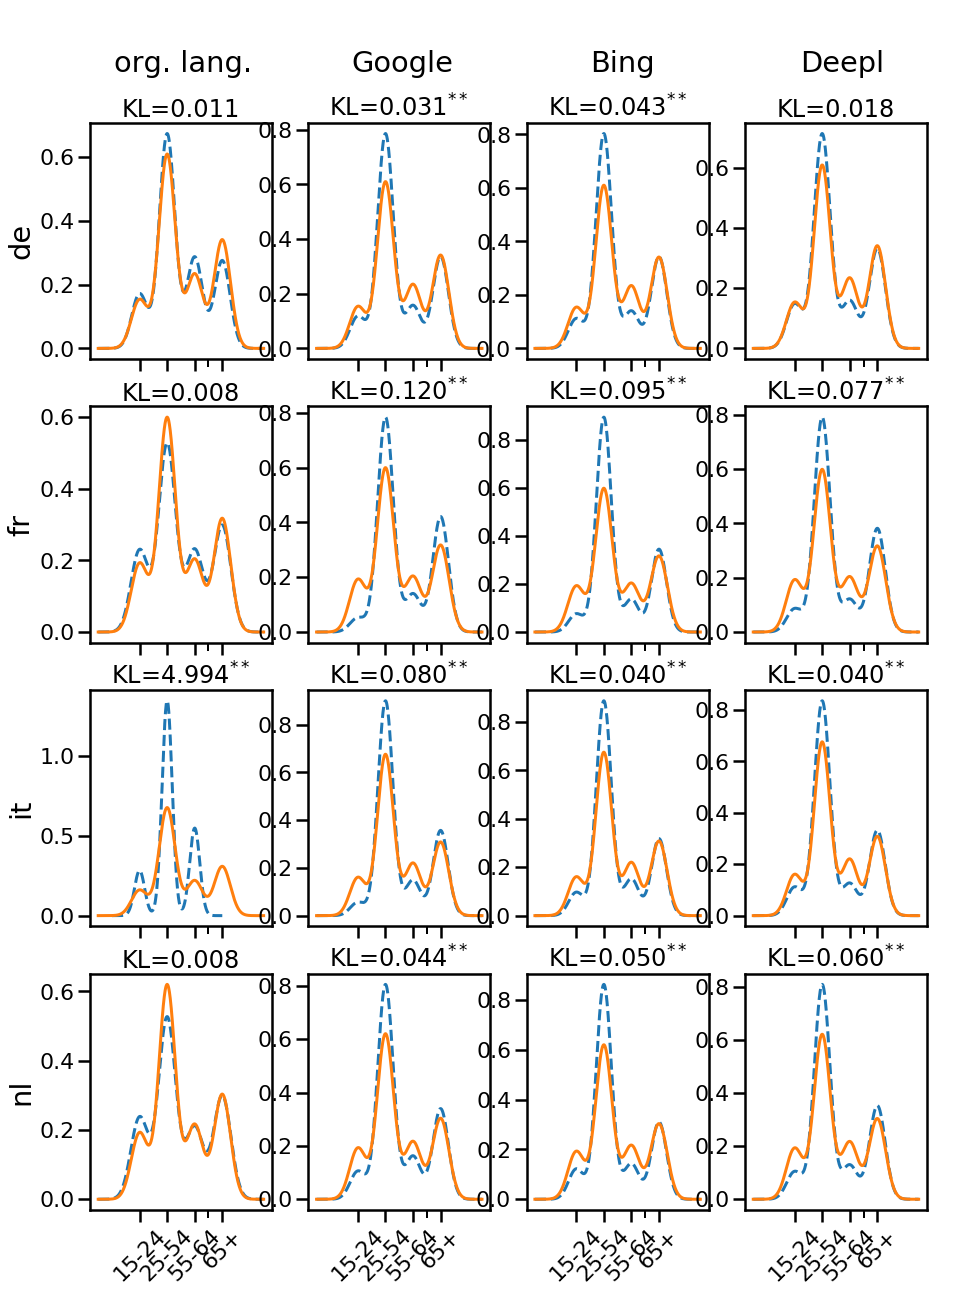

In [135]:
sb.set_context('poster')

fig, ax = plt.subplots(nrows=4, ncols=4, sharex=True, sharey=False, figsize=(15,20))
pos = [0.42, 0.65, 0.88]
ax[0, 0].annotate('org. lang.', xy=(0.19, 0.95), xytext=(1, 1),
                xycoords='figure fraction', textcoords='offset points',
                size='large', ha='center', va='center')

for l, lang in enumerate('de fr it nl'.split()):
    kl = get_kl(test_sets_y['age_cat'][lang], predictions_org['age_cat'][lang])
    significance = get_significance(test_sets_y['age_cat'][lang], predictions_org['age_cat'][lang])
    pd.DataFrame({lang:predictions_org['age_cat'][lang], 
                  'gold': test_sets_y['age_cat'][lang]}).plot.kde(ax=ax[l, 0], title='KL={}{}'.format(kl,significance), style=['--', '-'])
    ax[l, 0].set_ylabel(lang, rotation=90, size='large')
    ax[l, 0].get_legend().remove()
    ax[3, 0].set_xticklabels(age_brackets[1:], rotation=45)
    
    for t, transl in enumerate('google_translation bing_translation deepl_translation'.split()):
        if l == 0:
            ax[0, t+1].annotate(transl.split('_')[0].title(), xy=(pos[t], 0.95), xytext=(1, 1),
                xycoords='figure fraction', textcoords='offset points',
                size='large', ha='center', va='center')
        
        klt = get_kl(test_sets_y['age_cat'][lang], predictions_into_en['age_cat'][lang][transl])
        significancet = get_significance(test_sets_y['age_cat'][lang], predictions_into_en['age_cat'][lang][transl])
        pd.DataFrame({transl.split('_')[0].title():predictions_into_en['age_cat'][lang][transl], 
                      'gold': test_sets_y['age_cat'][lang]}).plot.kde(ax=ax[l, t+1],                                                                                                                                                  title='KL={}{}'.format(klt, significancet), 
                                                                                                                                                 style=['--', '-'])
        ax[l, t+1].get_legend().remove()
        ax[l, t+1].set_ylabel(None)
        ax[3, t+1].set_xticklabels(age_brackets[1:], rotation=45)

ax[0, 0].set_xticks(list(range(4)), minor=False)
fig.savefig('age_into_en.png', dpi=150, bbox_inches='tight', pad_inches=0.1)

## from English

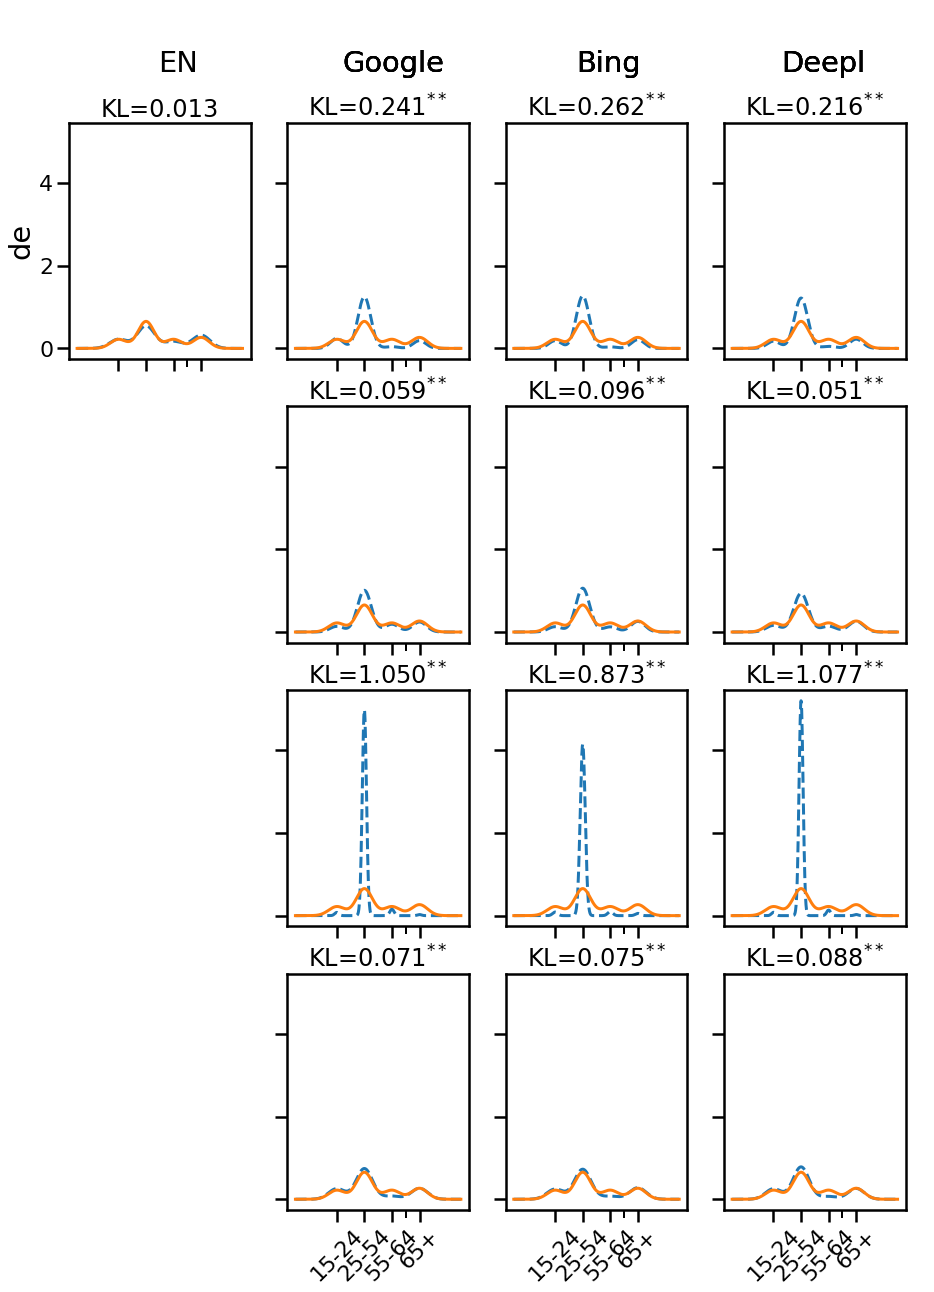

In [139]:
fig, ax = plt.subplots(nrows=4, ncols=4, sharex=True, sharey=True, figsize=(15,20))
pos = [0.42, 0.65, 0.88]

kl = get_kl(test_sets_y['age_cat']['en_us'], predictions_org['age_cat']['en_us'])
significance = get_significance(test_sets_y['age_cat']['en_us'], predictions_org['age_cat']['en_us'])
pd.DataFrame({lang:predictions_org['age_cat']['en_us'], 'gold': test_sets_y['age_cat']['en_us']}).plot.kde(ax=ax[0, 0], title='KL={}{}'.format(kl, significance), style=['--', '-'])
ax[0, 0].annotate('EN', xy=(0.19, 0.95), xytext=(1, 1),
                xycoords='figure fraction', textcoords='offset points',
                size='large', ha='center', va='center')
ax[0, 0].get_legend().remove()


for l, lang in enumerate('de fr it nl'.split()):
    for t, transl in enumerate('google_translation bing_translation deepl_translation'.split()):
        ax[0, t+1].annotate(transl.split('_')[0].title(), xy=(pos[t], 0.95), xytext=(1, 1),
            xycoords='figure fraction', textcoords='offset points',
            size='large', ha='center', va='center')
        
        klt = get_kl(test_sets_y['age_cat']['en_us'], predictions_from_en['age_cat'][lang][transl])
        significancet = get_significance(test_sets_y['age_cat']['en_us'], predictions_from_en['age_cat'][lang][transl])

        pd.DataFrame({transl.split('_')[0].title():predictions_from_en['age_cat'][lang][transl],
                      'EN':test_sets_y['age_cat']['en_us']
                     }).plot.kde(ax=ax[l, t+1], title='KL={}{}'.format(klt, significancet), style=['--', '-'])
        ax[l, t+1].get_legend().remove()
        if l == 0 or t > 0:
            ax[l, t+1].set_ylabel(None)
        ax[3, t+1].set_xticklabels(age_brackets[1:], rotation=45)

        
    if l > 0:
        ax[l, 0].set_axis_off()
        
    k = 0 if l == 0 else 1
    ax[l, k].set_ylabel(lang, rotation=90, size='large')

ax[0, 0].set_xticks(list(range(4)), minor=False)
ax[0, 0].set_xticklabels(age_brackets[1:], rotation=45)

        
fig.savefig('age_from_en.png', dpi=150, bbox_inches='tight', pad_inches=0.1)

# Decade into English

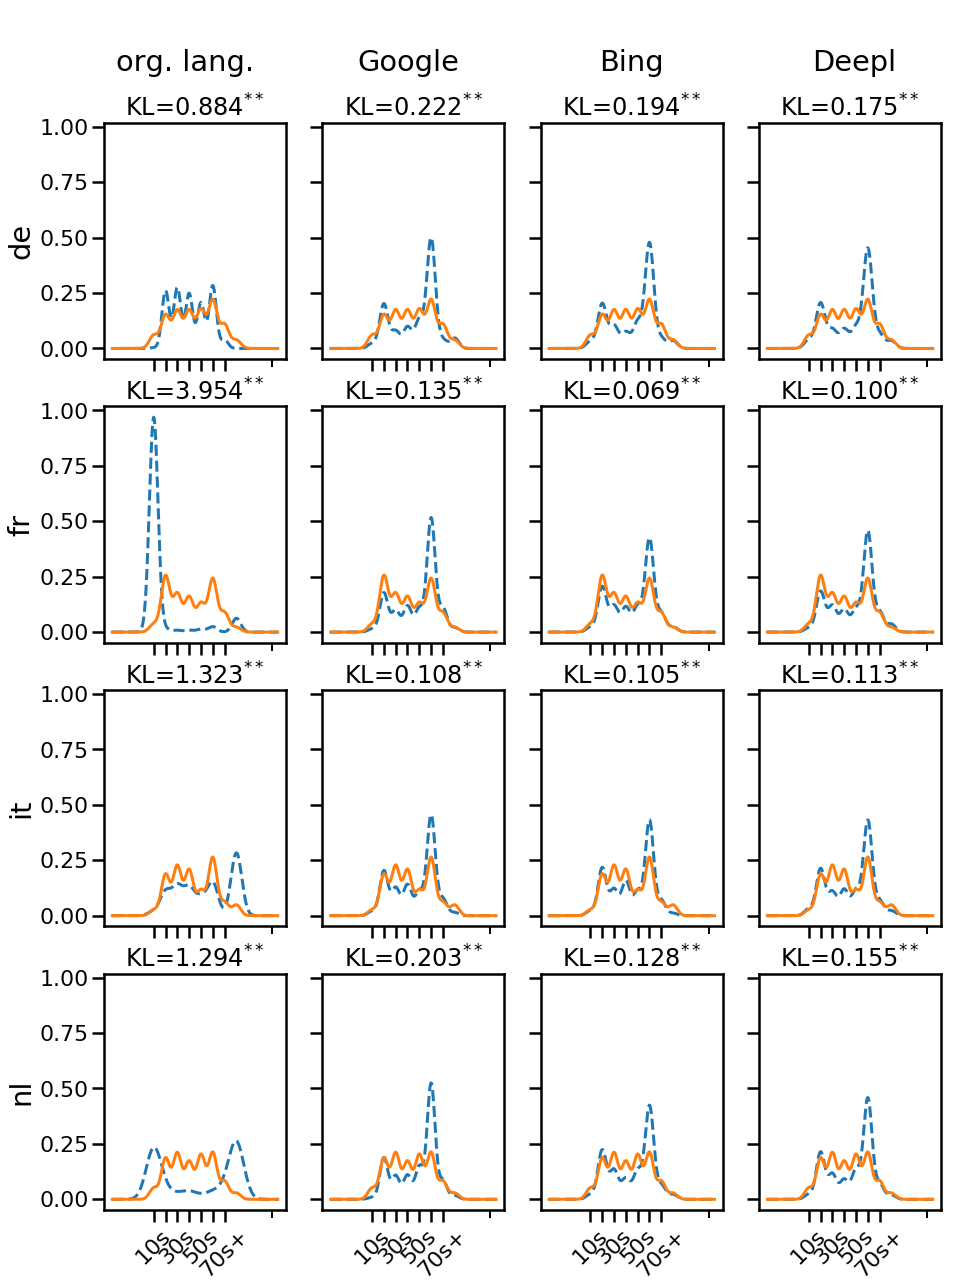

In [140]:
fig, ax = plt.subplots(nrows=4, ncols=4, sharex=True, sharey=True, figsize=(15,20))
pos = [0.42, 0.65, 0.88]
ax[0, 0].annotate('org. lang.', xy=(0.19, 0.95), xytext=(1, 1),
                xycoords='figure fraction', textcoords='offset points',
                size='large', ha='center', va='center')

for l, lang in enumerate('de fr it nl'.split()):
    kl = get_kl(test_sets_y['decade'][lang], predictions_org['decade'][lang])
    significance = get_significance(test_sets_y['decade'][lang], predictions_org['decade'][lang])
    pd.DataFrame({lang:predictions_org['decade'][lang], 
                  'gold': test_sets_y['decade'][lang]}).plot.kde(ax=ax[l, 0], 
                                                                 title='KL={}{}'.format(kl, significance), 
                                                                 style=['--', '-'], 
                                                                 bw_method=0.2)
    ax[l, 0].set_ylabel(lang, rotation=90, size='large')
    ax[l, 0].get_legend().remove()
    ax[3, 0].set_xticklabels('10s, ,30s, ,50s, ,70s+'.split(','), rotation=45)

    for t, transl in enumerate('google_translation bing_translation deepl_translation'.split()):
        if l == 0:
            ax[0, t+1].annotate(transl.split('_')[0].title(), xy=(pos[t], 0.95), xytext=(1, 1),
                xycoords='figure fraction', textcoords='offset points',
                size='large', ha='center', va='center')
        
        klt = get_kl(test_sets_y['decade'][lang], predictions_into_en['decade'][lang][transl])
        significancet = get_significance(test_sets_y['decade'][lang], predictions_into_en['decade'][lang][transl])
        pd.DataFrame({transl.split('_')[0].title():predictions_into_en['decade'][lang][transl], 
                      'gold': test_sets_y['decade'][lang]}).plot.kde(ax=ax[l, t+1], 
                                                                     title='KL={}{}'.format(klt, significancet), 
                                                                     style=['--', '-'], 
                                                                     bw_method=0.2)
        ax[l, t+1].get_legend().remove()
        ax[l, t+1].set_ylabel(None)
        ax[3, t+1].set_xticklabels('10s, ,30s, ,50s, ,70s+'.split(','), rotation=45)

ax[0, 0].set_xticks(list(range(7)), minor=False)

        
fig.savefig('decade_into_en.png', dpi=150, bbox_inches='tight', pad_inches=0.1)

## decade from English

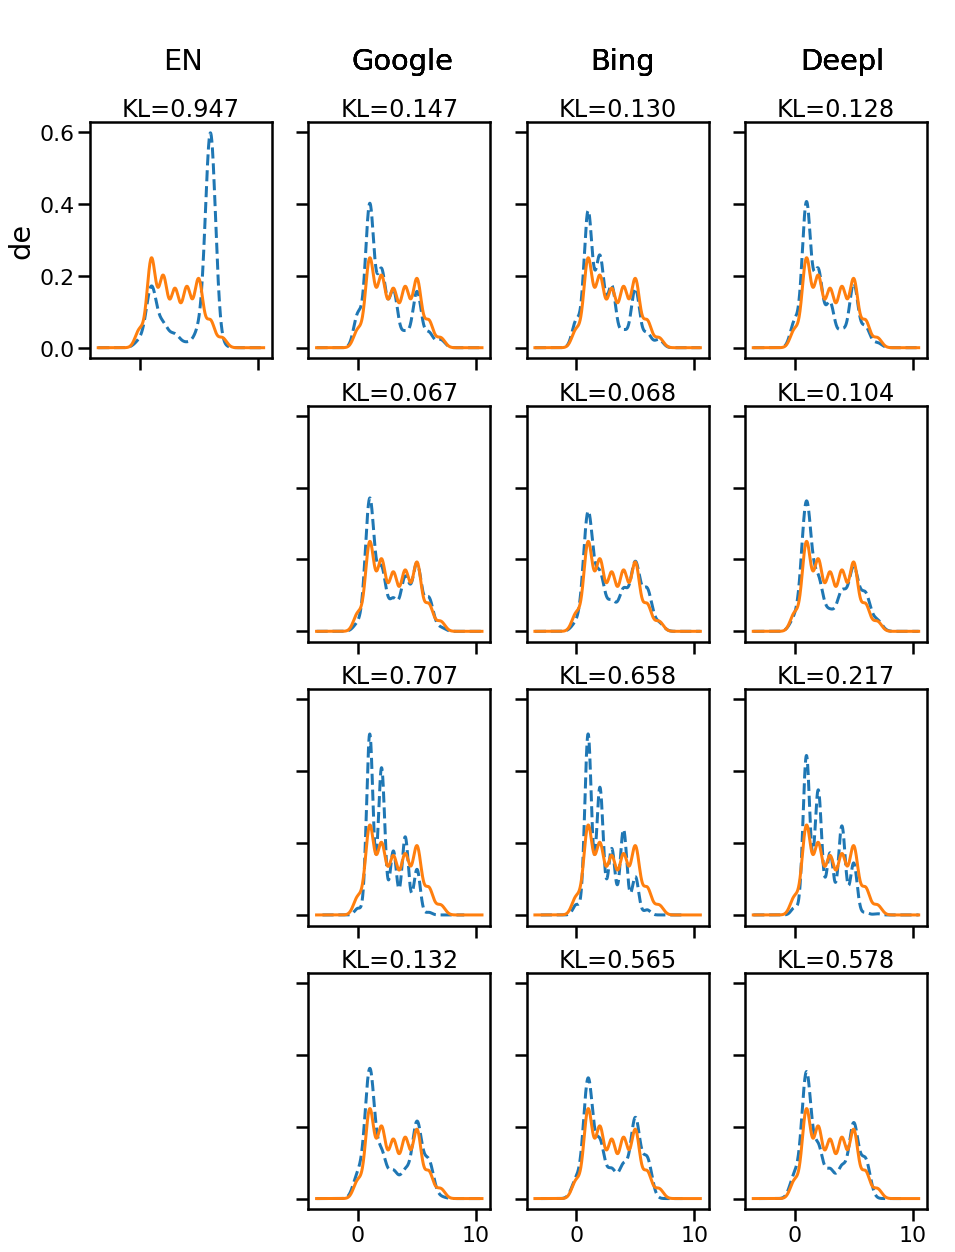

In [142]:
fig, ax = plt.subplots(nrows=4, ncols=4, sharex=True, sharey=True, figsize=(15,20))
pos = [0.42, 0.65, 0.88]

kl = get_kl(test_sets_y['decade']['en_us'], predictions_org['decade']['en_us'])
pd.DataFrame({lang:predictions_org['decade']['en_us'], 
              'gold': test_sets_y['decade']['en_us']}).plot.kde(ax=ax[0, 0],
                                                                title='KL={}'.format(kl),
                                                                style=['--', '-'],
                                                                bw_method=0.2)
ax[0, 0].annotate('EN', xy=(0.19, 0.95), xytext=(1, 1),
                xycoords='figure fraction', textcoords='offset points',
                size='large', ha='center', va='center')
ax[0, 0].get_legend().remove()


for l, lang in enumerate('de fr it nl'.split()):
    for t, transl in enumerate('google_translation bing_translation deepl_translation'.split()):
        ax[0, t+1].annotate(transl.split('_')[0].title(), xy=(pos[t], 0.95), xytext=(1, 1),
            xycoords='figure fraction', textcoords='offset points',
            size='large', ha='center', va='center')
        
        klt = get_kl(test_sets_y['decade']['en_us'], predictions_from_en['decade'][lang][transl])
        pd.DataFrame({transl.split('_')[0].title():predictions_from_en['decade'][lang][transl],
                      'EN':test_sets_y['decade']['en_us']
                     }).plot.kde(ax=ax[l, t+1], title='KL={}'.format(klt), style=['--', '-'], bw_method=0.2)
        ax[l, t+1].get_legend().remove()
        if l == 0 or t > 0:
            ax[l, t+1].set_ylabel(None)
        
    if l > 0:
        ax[l, 0].set_axis_off()
        
    k = 0 if l == 0 else 1
    ax[l, k].set_ylabel(lang, rotation=90, size='large')

        
fig.savefig('decade_from_en.png', dpi=150, bbox_inches='tight', pad_inches=0.1)